In [3]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
import os
import random
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Final Submission
Hi Kian and Ramtin,

This is our final submission. In this file you will find a model that combines both temporal and non-temporal data. Below you will see test evaluations of tensorflow saved models for just temporal data as well as one result of the combined model. You can probably just ignore the second attendance rnn class as it's mostly repeated code (working on refactoring soon).

All of the evaluations use a weighted cross entropy loss; the weight is a maximum likelihood estimate based on the probability of dropout labels appearing. One of the things we need to improve with the model going forward is this loss function, so any feedback on this would be greatly appreciated.

We trained a network that runs an RNN on the attendance data, some FC layers on the non-temporal student information, and then combined the final outputs of these networks, passed them through some FC layers until we produce one output.

We've designed this class to be flexible. We can change cell types, and we can make the RNN deeper as needed. We can also train models from any starting epoch, and load prior weights easily as needed. We will explore more types of models soon, but based on the fact that each and every model ultimately overfits the training set, we probably will have to tweak the loss function or the representation before we do that.

Lots of data cleaning was done up to this point. We represent each student's attendance as a (num_classes, num_days) matrix, and we represented each attendance symbol with a particular number. I think this representation still needs work as well in order for the model to perform better.

Overall, I'm really happy with our progress and I'm really greatful for this course because I learned a lot. Thank you for your help!

In [9]:
import dill, os
def save_dict(d, outfilepath):
    with open(outfilepath, "wb+") as f:
        dill.dump(d, f)
def load_dict(infilepath):
    d = {}
    with open(infilepath, "rb") as f:
        d = dill.load(f)
    return d

### Data Directory
Change the below cell to use the first line in the FloydHub environment and the second line locally.

In [10]:
# DATA_DIR = "/data-clean-attendance"
DATA_DIR = "../data/clean/attendance"

You can see dimensions of the training example here. The label is 0/1 binary classification.

In [11]:
d_attendance = load_dict(DATA_DIR + "/train/attendance_minibatch_0.dill")
print ("Attendance example matrix dimensions: %s" % str(d_attendance["S009505507"].T.shape))
d_test = load_dict(DATA_DIR + "/train/test_minibatch_0.dill")
print ("Test score example matrix dimensions: %s" % str(d_test["S009505507"].shape))

Attendance example matrix dimensions: (372, 1906)
Test score example matrix dimensions: (111, 1)


### Model Code
Below you'll see the code for my model. Pay close attention to the `build()` method, as well as the `fit()` and `predict()` methods. You'll see that creating the model calls `build()` to create the TensorFlow graph, and `fit()` and `predict()` runs training-validation over epochs and testing respectively.

In [12]:
###############################################################################

class AttendanceTestModel:
    def __init__(self, num_units = 16, lr = 1e-4, num_epochs = 5, 
                 num_layers = 1, cell_type = 'lstm', window_size = 6,
                 labels_filepath = DATA_DIR + "/labels_dict_grade_10.dill",
                 epoch_offset = 0,
                 train_files_in_memory = False,
                 activation_fn = "relu",
                 pca_dim = None,
                 initial_fc_hidden_dims = [50, 25, 10],
                 combined_hidden_dims = [20, 10],
                 weighted = True, hs_dropout_prob = 0.1781):
        
        self.num_days = 31 * 12
        self.num_classes = 1906
        self.num_test_data_inputs = 111
        
        # Number of days fed in at each time step.
        self.window_size = window_size
        if self.num_days % self.window_size > 0:
            raise Exception(
                "Invalid window size %s, must evenly divide timestep dimensions %s." % 
                (self.window_size, self.num_days)
            )
        
        self.num_units = num_units
        self.lr = lr
        self.num_epochs = num_epochs
        
        self.num_layers = num_layers
        
        # One of 'vanilla', 'gru', 'lstm'.
        self.cell_type = cell_type
        
        self.labels_dict = load_dict(labels_filepath)
        
        self.epoch_offset = epoch_offset
        self.train_files_in_memory = train_files_in_memory
        
        self.activation_fn = activation_fn
        
        self.pca_dim = pca_dim
        
        self.initial_fc_hidden_dims = initial_fc_hidden_dims
        self.combined_hidden_dims = combined_hidden_dims
        
        self.weighted = weighted
        if self.weighted:
            self.pos_weight = (1 - hs_dropout_prob) / hs_dropout_prob
        
        self.build()
    
    def build(self):
        self.add_placeholders()
        self.final_fc_output, self.final_rnn_output, self.yhat = self.forward_prop()
        self.loss = self.add_loss_op()
        self.train_op = self.add_train_op()
    
    def add_placeholders(self):
        self.attendance_inputs = tf.placeholder(shape=(
            None,
            self.num_days // self.window_size,
            self.pca_dim if self.pca_dim else self.num_classes * self.window_size
        ), dtype=tf.float32)
        self.test_inputs = tf.placeholder(shape=(
            None,
            self.num_test_data_inputs
        ), dtype=tf.float32)
        self.labels = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    
    def create_feed_dict(self, attendance_inputs, test_inputs, labels=None):
        feed_dict = {}
        feed_dict[self.attendance_inputs] = attendance_inputs
        feed_dict[self.test_inputs] = test_inputs
        if labels is not None:
            feed_dict[self.labels] = labels
        return feed_dict
    
    def forward_prop(self):
        stacked_cells = []
        
        activation_fn = None
        if self.activation_fn == "relu":
            activation_fn = tf.nn.relu
        if self.activation_fn == "tanh":
            activation_fn = tf.nn.tanh
        if self.activation_fn == "sigmoid":
            activation_fn = tf.nn.sigmoid
        
        for _ in range(self.num_layers):
            if self.cell_type == 'lstm':
                cell = tf.contrib.rnn.LSTMCell(
                    num_units = self.num_units,
                    initializer=tf.contrib.layers.xavier_initializer(),
                    activation=activation_fn
                )
            elif self.cell_type == 'gru':
                cell = tf.contrib.rnn.GRUCell(
                    self.num_units,
                    activation_fn,
                    kernel_initializer=tf.contrib.layers.xavier_initializer()
                )
            else:
                cell = tf.contrib.rnn.BasicRNNCell(self.num_units, activation_fn)

            '''
            cell = tf.contrib.rnn.DropoutWrapper(
                cell, output_keep_prob = 1.0 - dropout
            )
            '''
            stacked_cells.append(cell)
        
        one_rolled_cell = tf.contrib.rnn.MultiRNNCell(stacked_cells)
        
        output, state = tf.nn.dynamic_rnn(one_rolled_cell, self.attendance_inputs, dtype=tf.float32)
        final_rnn_output = output[:,-1,:]
        
        # start fc layer forward prop
        final_fc_output = self.test_inputs
        for fc_dim in self.initial_fc_hidden_dims:
             final_fc_output = tf.contrib.layers.fully_connected(final_fc_output, fc_dim, activation_fn=activation_fn)
        
        combined_state = tf.concat([final_fc_output, final_rnn_output], 1)
        for fc_dim in self.combined_hidden_dims:
            combined_state = tf.contrib.layers.fully_connected(combined_state, fc_dim, activation_fn=activation_fn)
        
        # Returns yhat before sigmoid (computed in loss).
        yhat = tf.contrib.layers.fully_connected(combined_state, 1, activation_fn=None)
        return (final_fc_output, final_rnn_output, yhat)
    
    def add_loss_op(self):
        if not self.weighted:
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = self.yhat, labels = self.labels))
            return loss
        else:
            loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.labels, self.yhat, self.pos_weight))
            return loss
    
    def add_train_op(self):
        train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        return train_op
    
    def run_batch(self, sess, attendance_inputs, test_inputs, labels, should_train = True):
        feed_dict = self.create_feed_dict(
            attendance_inputs=attendance_inputs,
            test_inputs=test_inputs,
            labels=labels
        )
        batch_loss = sess.run(self.loss, feed_dict=feed_dict)
        if should_train:
            _ = sess.run(self.train_op, feed_dict=feed_dict)
        return batch_loss
    
    def run_batches(self, sess, all_attendance_inputs, all_test_inputs, all_labels, should_train = True):
        num_input_files = len(all_attendance_inputs)
        
        random_minibatch_order = list(range(num_input_files))
        random.shuffle(random_minibatch_order)

        epoch_loss = 0
        for minibatch_index in random_minibatch_order:
            
            attendance_inputs = all_attendance_inputs[minibatch_index]
            test_inputs = all_test_inputs[minibatch_index]
            labels = all_labels[minibatch_index]
            
            epoch_loss += self.run_batch(sess, 
                attendance_inputs, test_inputs, labels, should_train = should_train)

        epoch_loss /= num_input_files
        return epoch_loss
    
    def train_epoch(self, sess, train_all_attendance_inputs, train_all_test_inputs, train_all_labels):
        return self.run_batches(sess, 
            train_all_attendance_inputs, train_all_test_inputs, train_all_labels, should_train = True)
    def validate(self, sess, validation_all_attendance_inputs, validation_all_test_inputs, validation_all_labels):
        return self.run_batches(sess,
            validation_all_attendance_inputs, validation_all_test_inputs, validation_all_labels, should_train = False)
    
    def get_inputs_and_labels(self, input_filepaths):
        attendance_filepath, test_filepath = input_filepaths
        
        test_batch_dict = load_dict(test_filepath)
        attendance_batch_dict = load_dict(attendance_filepath)
        
        m = len(test_batch_dict)
        T_x = self.num_days // self.window_size
        n_x = self.num_classes * self.window_size
        
        studentnos_in_batch = list(test_batch_dict.keys())

        attendance_inputs = np.array([
            np.transpose(attendance_batch_dict[studentno]).reshape(T_x, n_x) for studentno in studentnos_in_batch],
            dtype=np.float32
        )
        
        if self.pca_dim:
            pca_inputs = np.zeros((m, T_x, self.pca_dim))
            pca = PCA(n_components=self.pca_dim)
            for i in range(m):
                pca = PCA(n_components=self.pca_dim)
                pca.fit(attendance_inputs[i])
                pca_inputs[i] = pca.transform(attendance_inputs[i])
            attendance_inputs = pca_inputs
        
        test_inputs = np.array([
            test_batch_dict[studentno].reshape(self.num_test_data_inputs) for studentno in studentnos_in_batch],
            dtype=np.float32
        )
        
        labels = np.array([
            self.labels_dict[studentno] for studentno in studentnos_in_batch], dtype=np.float32
        ).reshape(m, 1)
        
        return (attendance_inputs, test_inputs, labels)
    
    def get_minibatch_filepaths(self, minibatch_filedir):
        minibatch_filepaths = []
        for dirpath, _, files in os.walk(minibatch_filedir):
            for file in files:
                if file.startswith("attendance_minibatch") and file.endswith('.dill'):
                    attendance_file = file
                    test_file = "test" + file[10:]
                    
                    minibatch_filepaths.append((
                        os.path.join(dirpath, attendance_file),
                        os.path.join(dirpath, test_file)
                    ))
        random.shuffle(minibatch_filepaths)
        return minibatch_filepaths
    
    def get_minibatches(self, minibatch_filedir):

        minibatch_filepaths = self.get_minibatch_filepaths(minibatch_filedir)
        
        all_attendance_inputs, all_test_inputs, all_labels = [], [], []
        for filepath_i, input_filepaths in enumerate(minibatch_filepaths):
            
            print ("Getting both sets of inputs and labels for filepath %s: %s" % (filepath_i, input_filepaths[0]))
            attendance_inputs, test_inputs, labels = self.get_inputs_and_labels(input_filepaths)
            
            all_attendance_inputs.append(attendance_inputs)
            all_test_inputs.append(test_inputs)
            all_labels.append(labels)
        
        return (all_attendance_inputs, all_test_inputs, all_labels)
    
    def get_model_folder(self, epoch,
                         saved_models_folder = "../models/attendance_test_model/"):
        
        model_sub_folder = "%s_%s_memory_%s_depth_%s_window_%s_%s%s" % (
            self.cell_type,
            self.activation_fn,
            self.num_units,
            self.num_layers,
            self.window_size,
            "weighted" if self.weighted else "unweighted",
            "_pca_%s" % self.pca_dim if self.pca_dim else ""
        )
        
        return os.path.join(
            saved_models_folder,
            model_sub_folder,
            'attendance_test_rnn-%s' % epoch
        )
    
    def fit(self, sess, saver,
            train_minibatch_filedir = DATA_DIR + "/train/",
            validation_minibatch_filedir = DATA_DIR + "/validation/",
            saved_models_folder = "../models/attendance_rnn/"):
        
        if self.epoch_offset > 0:
            print ('***** LOADING WEIGHTS FROM PREVIOUS SESSION (EPOCH %s) *****' % self.epoch_offset)
            saver.restore(sess, self.get_model_folder(self.epoch_offset))
        else:
            print ('***** LOADING WEIGHTS FROM RANDOM INITIALIZATION *****')
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
        
        train_losses = []
        validation_losses = []
        
        print ("***** LOADING TRAINING AND VALIDATION FILES INTO MEMORY *****")
        
        
        if self.train_files_in_memory:
            train_all_attendance_inputs, train_all_test_inputs, train_all_labels = \
                self.get_minibatches(train_minibatch_filedir)
        
        validation_all_attendance_inputs, validation_all_test_inputs, validation_all_labels = \
            self.get_minibatches(validation_minibatch_filedir)
                
        print('***** BEGIN TRAINING (%s EPOCHS) *****' % self.num_epochs)
        
        for current_epoch in range(1 + self.epoch_offset, self.num_epochs + self.epoch_offset + 1):
            
            print('***** Epoch %s *****' % (current_epoch))
            
            '''
            # The below line causes a memory error. We have to load in the batch files one at a time.
            train_losses.append(self.train_epoch(sess, train_all_inputs, train_all_labels))
            
            # Therefore, the below code for loading in each training minibatch
            #     one at a time exists.
            '''
            
            if self.train_files_in_memory:
                train_losses.append(self.train_epoch(sess, 
                    train_all_attendance_inputs, train_all_test_inputs, train_all_labels
                ))
            else:
                minibatch_filepaths = self.get_minibatch_filepaths(train_minibatch_filedir)

                random_minibatch_order = list(range(len(minibatch_filepaths)))
                random.shuffle(random_minibatch_order)

                train_epoch_loss = 0
                for minibatch_index in random_minibatch_order:
                    attendance_inputs, test_inputs, labels = self.get_inputs_and_labels(
                        minibatch_filepaths[minibatch_index]
                    )
                    
                    train_epoch_loss += self.run_batch(sess, 
                        attendance_inputs, test_inputs, labels, 
                        should_train = True)

                train_epoch_loss /= len(minibatch_filepaths)

                train_losses.append(train_epoch_loss)
            print('Average training loss for this epoch: %s' % (train_losses[-1]))
            
            validation_losses.append(self.validate(sess, 
                validation_all_attendance_inputs, validation_all_test_inputs, validation_all_labels))
            print('Average validation loss for this epoch: %s' % (validation_losses[-1]))
            
            if current_epoch == 5 or current_epoch % 50 == 0:
                saver.save(sess, self.get_model_folder(current_epoch))
                print('Saved model after this epoch: %s' % current_epoch)
        
        if self.num_epochs % 50 > 0:
            saver.save(sess, self.get_model_folder(current_epoch))
            print('Saved model after final epoch: %s' % self.num_epochs)
        
        print('***** FITTING COMPLETE *****')
        
        t = list(range(self.num_epochs))
        train_plot, = plt.plot(t, np.squeeze(train_losses), 'b')
        validation_plot, = plt.plot(t, np.squeeze(validation_losses), 'g')
        plt.legend([train_plot, validation_plot], ['train_loss', 'validation_loss'])
        plt.ylabel('losses')
        plt.xlabel('iterations')
        plt.title('lr = %s' % self.lr)
        plt.show()
    
    def predict(self, sess, saver,
                test_minibatch_filedir = DATA_DIR + "/test/"):
        
        print ("Testing predictions on minibatches in following directory: %s" % test_minibatch_filedir)
        
        if self.epoch_offset > 0:
            print ('***** LOADING WEIGHTS FROM EPOCH %s *****' % self.epoch_offset)
            saver.restore(sess, self.get_model_folder(self.epoch_offset))
        else:
            raise Exception("Cannot predict without an epoch offset to load weights from.")
        
        print('***** BEGIN TESTING - LOADING TEST FILES *****')
        
        test_attendance_inputs, test_test_inputs, test_labels = self.get_minibatches(test_minibatch_filedir)
                
        attendance_inputs = np.vstack(test_attendance_inputs)
        test_inputs = np.vstack(test_test_inputs)
        labels = np.vstack(test_labels)
        
        feed_dict = self.create_feed_dict(
            attendance_inputs=attendance_inputs,
            test_inputs=test_inputs,
            labels=labels
        )
        final_rnn_output = sess.run(self.final_rnn_output, feed_dict=feed_dict)
        final_fc_output = sess.run(self.final_fc_output, feed_dict=feed_dict)
        yhat = sess.run(self.yhat, feed_dict=feed_dict)
        predictions = sess.run(tf.round(tf.sigmoid(yhat)))
        ground_truth = labels
        
        def show_tsne_plot(hidden_state, ground_truth, title):
            X_tsne = TSNE(n_components=2).fit_transform(final_rnn_output)
            dropout_plot = plt.scatter(
                X_tsne[ground_truth[:,0] == 1][:,0],
                X_tsne[ground_truth[:,0] == 1][:,1],
                c = "r", s = 5
            )
            stay_plot = plt.scatter(
                X_tsne[ground_truth[:,0] == 0][:,0],
                X_tsne[ground_truth[:,0] == 0][:,1],
                c = "b", s = 5
            )
            plt.legend(
                (dropout_plot, stay_plot),
                ('dropout after grade 10', 'in school after grade 10'),
                scatterpoints = 1
            )
            plt.title('%s tsne (state_dim = %s)' % (title, final_rnn_output.shape[1]))
            plt.show()
            
        show_tsne_plot(final_rnn_output, ground_truth, "attendance")
        show_tsne_plot(final_fc_output, ground_truth, "test score data")

        print (classification_report(ground_truth, predictions))
        
###############################################################################

In [17]:
###############################################################################

class AttendanceRNN:
    def __init__(self, num_units = 16, lr = 1e-4, num_epochs = 5, 
                 num_layers = 1, cell_type = 'lstm', window_size = 6,
                 labels_filepath = DATA_DIR + "/labels_dict_grade_10.dill",
                 epoch_offset = 0,
                 train_files_in_memory = False,
                 activation_fn = "relu",
                 pca_dim = None,
                 weighted = True, hs_dropout_prob = 0.1781):
        
        self.num_days = 31 * 12
        self.num_classes = 1906
        
        # Number of days fed in at each time step.
        self.window_size = window_size
        if self.num_days % self.window_size > 0:
            raise Exception(
                "Invalid window size %s, must evenly divide timestep dimensions %s." % 
                (self.window_size, self.num_days)
            )
        
        self.num_units = num_units
        self.lr = lr
        self.num_epochs = num_epochs
        
        self.num_layers = num_layers
        
        # One of 'vanilla', 'gru', 'lstm'.
        self.cell_type = cell_type
        
        self.labels_dict = load_dict(labels_filepath)
        
        self.epoch_offset = epoch_offset
        self.train_files_in_memory = train_files_in_memory
        
        self.activation_fn = activation_fn
        
        self.pca_dim = pca_dim
        
        self.weighted = weighted
        if self.weighted:
            self.pos_weight = (1 - hs_dropout_prob) / hs_dropout_prob
        
        self.build()
    
    def build(self):
        self.add_placeholders()
        self.final_output, self.yhat = self.forward_prop()
        self.loss = self.add_loss_op()
        self.train_op = self.add_train_op()
    
    def add_placeholders(self):
        self.inputs = tf.placeholder(shape=(
            None,
            self.num_days // self.window_size,
            self.pca_dim if self.pca_dim else self.num_classes * self.window_size
        ), dtype=tf.float32)
        self.labels = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    
    def create_feed_dict(self, inputs, labels=None):
        feed_dict = {}
        feed_dict[self.inputs] = inputs
        if labels is not None:
            feed_dict[self.labels] = labels
        return feed_dict
    
    def forward_prop(self):
        stacked_cells = []
        
        activation_fn = None
        if self.activation_fn == "relu":
            activation_fn = tf.nn.relu
        if self.activation_fn == "tanh":
            activation_fn = tf.nn.tanh
        if self.activation_fn == "sigmoid":
            activation_fn = tf.nn.sigmoid
        
        for _ in range(self.num_layers):
            if self.cell_type == 'lstm':
                cell = tf.contrib.rnn.LSTMCell(
                    num_units = self.num_units,
                    initializer=tf.contrib.layers.xavier_initializer(),
                    activation=activation_fn
                )
            elif self.cell_type == 'gru':
                cell = tf.contrib.rnn.GRUCell(
                    self.num_units,
                    activation_fn,
                    kernel_initializer=tf.contrib.layers.xavier_initializer()
                )
            else:
                cell = tf.contrib.rnn.BasicRNNCell(self.num_units, activation_fn)

            '''
            cell = tf.contrib.rnn.DropoutWrapper(
                cell, output_keep_prob = 1.0 - dropout
            )
            '''
            stacked_cells.append(cell)
        
        one_rolled_cell = tf.contrib.rnn.MultiRNNCell(stacked_cells)
        
        output, state = tf.nn.dynamic_rnn(one_rolled_cell, self.inputs, dtype=tf.float32)
        final_output = output[:,-1,:]
        
        # Returns yhat before sigmoid (computed in loss).
        yhat = tf.contrib.layers.fully_connected(final_output, 1, activation_fn=None)
        return (final_output, yhat)
    
    def add_loss_op(self):
        if not self.weighted:
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = self.yhat, labels = self.labels))
            return loss
        else:
            loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.labels, self.yhat, self.pos_weight))
            return loss
    
    def add_train_op(self):
        train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        return train_op
    
    def run_batch(self, sess, inputs, labels, should_train = True):
        feed_dict = self.create_feed_dict(inputs=inputs, labels=labels)
        batch_loss = sess.run(self.loss, feed_dict=feed_dict)
        if should_train:
            _ = sess.run(self.train_op, feed_dict=feed_dict)
        return batch_loss
    
    def run_batches(self, sess, all_inputs, all_labels, should_train = True):
        num_input_files = len(all_inputs)
        
        random_minibatch_order = list(range(num_input_files))
        random.shuffle(random_minibatch_order)

        epoch_loss = 0
        for minibatch_index in random_minibatch_order:
            inputs = all_inputs[minibatch_index]
            labels = all_labels[minibatch_index]
            epoch_loss += self.run_batch(sess, inputs, labels, should_train = should_train)

        epoch_loss /= num_input_files
        return epoch_loss
    
    def train_epoch(self, sess, train_all_inputs, train_all_labels):
        return self.run_batches(sess, train_all_inputs, train_all_labels, should_train = True)
    def validate(self, sess, validation_all_inputs, validation_all_labels):
        return self.run_batches(sess, validation_all_inputs, validation_all_labels, should_train = False)
    
    def get_inputs_and_labels(self, input_filepath):
        input_batch_dict = load_dict(input_filepath)
        
        m = len(input_batch_dict)
        T_x = self.num_days // self.window_size
        n_x = self.num_classes * self.window_size
        
        studentnos_in_batch = list(input_batch_dict.keys())

        inputs = np.array([
            np.transpose(input_batch_dict[studentno]).reshape(T_x, n_x) for studentno in studentnos_in_batch],
            dtype=np.float32
        )
        
        if self.pca_dim:
            pca_inputs = np.zeros((m, T_x, self.pca_dim))
            pca = PCA(n_components=self.pca_dim)
            for i in range(m):
                pca = PCA(n_components=self.pca_dim)
                pca.fit(inputs[i])
                pca_inputs[i] = pca.transform(inputs[i])
            inputs = pca_inputs
        
        labels = np.array([
            self.labels_dict[studentno] for studentno in studentnos_in_batch], dtype=np.float32
        ).reshape(m, 1)
            
        return (inputs, labels)
    
    def get_minibatch_filepaths(self, minibatch_filedir):
        minibatch_filepaths = []
        for dirpath, _, files in os.walk(minibatch_filedir):
            for file in files:
                if file.startswith("attendance_minibatch") and file.endswith('.dill'):
                    minibatch_filepaths.append(os.path.join(dirpath, file))
        random.shuffle(minibatch_filepaths)
        return minibatch_filepaths
    
    def get_minibatches(self, minibatch_filedir):

        minibatch_filepaths = self.get_minibatch_filepaths(minibatch_filedir)
        
        all_inputs, all_labels = [], []
        for filepath_i, input_filepath in enumerate(minibatch_filepaths):
            
            print ("Getting inputs and labels for filepath %s: %s" % (filepath_i, input_filepath))
            inputs, labels = self.get_inputs_and_labels(input_filepath)
            
            all_inputs.append(inputs)
            all_labels.append(labels)
        
        return (all_inputs, all_labels)
    
    def get_model_folder(self, epoch,
                         saved_models_folder = "../models/attendance_rnn/"):
        
        model_sub_folder = "%s_%s_memory_%s_depth_%s_window_%s_%s%s" % (
            self.cell_type,
            self.activation_fn,
            self.num_units,
            self.num_layers,
            self.window_size,
            "weighted" if self.weighted else "unweighted",
            "_pca_%s" % self.pca_dim if self.pca_dim else ""
        )
        
        return os.path.join(
            saved_models_folder,
            model_sub_folder,
            'attendance_rnn-%s' % epoch
        )
    
    def fit(self, sess, saver,
            train_minibatch_filedir = DATA_DIR + "/train/",
            validation_minibatch_filedir = DATA_DIR + "/validation/",
            saved_models_folder = "../models/attendance_rnn/"):
        
        if self.epoch_offset > 0:
            print ('***** LOADING WEIGHTS FROM PREVIOUS SESSION (EPOCH %s) *****' % self.epoch_offset)
            saver.restore(sess, self.get_model_folder(self.epoch_offset))
        else:
            print ('***** LOADING WEIGHTS FROM RANDOM INITIALIZATION *****')
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
        
        train_losses = []
        validation_losses = []
        
        print ("***** LOADING TRAINING AND VALIDATION FILES INTO MEMORY *****")
        
        '''
        # The below line causes a memory error. We have to load in the batch files one at a time.
        train_all_inputs, train_all_labels = self.get_minibatches(train_minibatch_filedir)

        # Therefore, the below code for loading in each training minibatch
        #     one at a time exists.
        '''
        
        if self.train_files_in_memory:
            train_all_inputs, train_all_labels = self.get_minibatches(train_minibatch_filedir)
        validation_all_inputs, validation_all_labels = self.get_minibatches(validation_minibatch_filedir)
                
        print('***** BEGIN TRAINING (%s EPOCHS) *****' % self.num_epochs)
        
        for current_epoch in range(1 + self.epoch_offset, self.num_epochs + self.epoch_offset + 1):
            
            print('***** Epoch %s *****' % (current_epoch))
            
            '''
            # The below line causes a memory error. We have to load in the batch files one at a time.
            train_losses.append(self.train_epoch(sess, train_all_inputs, train_all_labels))
            
            # Therefore, the below code for loading in each training minibatch
            #     one at a time exists.
            '''
            
            if self.train_files_in_memory:
                train_losses.append(self.train_epoch(sess, train_all_inputs, train_all_labels))
            else:
                minibatch_filepaths = self.get_minibatch_filepaths(train_minibatch_filedir)

                random_minibatch_order = list(range(len(minibatch_filepaths)))
                random.shuffle(random_minibatch_order)

                train_epoch_loss = 0
                for minibatch_index in random_minibatch_order:
                    inputs, labels = self.get_inputs_and_labels(minibatch_filepaths[minibatch_index])
                    train_epoch_loss += self.run_batch(sess, inputs, labels, should_train = True)

                train_epoch_loss /= len(minibatch_filepaths)

                train_losses.append(train_epoch_loss)
            print('Average training loss for this epoch: %s' % (train_losses[-1]))
            
            validation_losses.append(self.validate(sess, validation_all_inputs, validation_all_labels))
            print('Average validation loss for this epoch: %s' % (validation_losses[-1]))
            
            if current_epoch == 5 or current_epoch % 50 == 0:
                saver.save(sess, self.get_model_folder(current_epoch))
                print('Saved model after this epoch: %s' % current_epoch)
        
        if self.num_epochs % 50 > 0:
            saver.save(sess, self.get_model_folder(current_epoch))
            print('Saved model after final epoch: %s' % self.num_epochs)
        
        print('***** FITTING COMPLETE *****')
        
        t = list(range(self.num_epochs))
        train_plot, = plt.plot(t, np.squeeze(train_losses), 'b')
        validation_plot, = plt.plot(t, np.squeeze(validation_losses), 'g')
        plt.legend([train_plot, validation_plot], ['train_loss', 'validation_loss'])
        plt.ylabel('losses')
        plt.xlabel('iterations')
        plt.title('lr = %s' % self.lr)
        plt.show()
    
    def predict(self, sess, saver,
                test_minibatch_filedir = DATA_DIR + "/test/"):
        
        print ("Testing predictions on minibatches in following directory: %s" % test_minibatch_filedir)
        
        if self.epoch_offset > 0:
            print ('***** LOADING WEIGHTS FROM EPOCH %s *****' % self.epoch_offset)
            saver.restore(sess, self.get_model_folder(self.epoch_offset))
        else:
            raise Exception("Cannot predict without an epoch offset to load weights from.")
        
        print('***** BEGIN TESTING - LOADING TEST FILES *****')
        
        test_inputs, test_labels = self.get_minibatches(test_minibatch_filedir)
                
        inputs = np.vstack(test_inputs)
        labels = np.vstack(test_labels)
        
        feed_dict = self.create_feed_dict(inputs=inputs, labels=labels)
        final_output = sess.run(self.final_output, feed_dict=feed_dict)
        yhat = sess.run(self.yhat, feed_dict=feed_dict)
        predictions = sess.run(tf.round(tf.sigmoid(yhat)))
        ground_truth = labels
        
        X_tsne = TSNE(n_components=2).fit_transform(final_output)
        dropout_plot = plt.scatter(
            X_tsne[ground_truth[:,0] == 1][:,0],
            X_tsne[ground_truth[:,0] == 1][:,1],
            c = "r", s = 5
        )
        stay_plot = plt.scatter(
            X_tsne[ground_truth[:,0] == 0][:,0],
            X_tsne[ground_truth[:,0] == 0][:,1],
            c = "b", s = 5
        )
        plt.legend(
            (dropout_plot, stay_plot),
            ('dropout after grade 10', 'in school after grade 10'),
            scatterpoints = 1
        )
        plt.title('tsne (state_dim = %s)' % final_output.shape[1])
        plt.show()
        
        print (classification_report(ground_truth, predictions))
        
###############################################################################

## Modular Model Structure
This model structure allows me to call generic `train()` and `test()` functions. See the training output below which is my model training for 200 epochs on the attendance and test score / demographic data. You'll have to click on the cell and scroll a bit.

In [18]:
def train(model):
    saver = tf.train.Saver(max_to_keep=None)    
    with tf.Session() as sess:
        model.fit(sess, saver)

***** LOADING WEIGHTS FROM RANDOM INITIALIZATION *****
***** LOADING TRAINING AND VALIDATION FILES INTO MEMORY *****
Getting inputs and labels for filepath 0: ('../data/clean/attendance/train/attendance_minibatch_17.dill', '../data/clean/attendance/train/test_minibatch_17.dill')
Getting inputs and labels for filepath 1: ('../data/clean/attendance/train/attendance_minibatch_50.dill', '../data/clean/attendance/train/test_minibatch_50.dill')
Getting inputs and labels for filepath 2: ('../data/clean/attendance/train/attendance_minibatch_33.dill', '../data/clean/attendance/train/test_minibatch_33.dill')
Getting inputs and labels for filepath 3: ('../data/clean/attendance/train/attendance_minibatch_51.dill', '../data/clean/attendance/train/test_minibatch_51.dill')
Getting inputs and labels for filepath 4: ('../data/clean/attendance/train/attendance_minibatch_22.dill', '../data/clean/attendance/train/test_minibatch_22.dill')
Getting inputs and labels for filepath 5: ('../data/clean/attendance

Getting inputs and labels for filepath 50: ('../data/clean/attendance/train/attendance_minibatch_4.dill', '../data/clean/attendance/train/test_minibatch_4.dill')
Getting inputs and labels for filepath 51: ('../data/clean/attendance/train/attendance_minibatch_81.dill', '../data/clean/attendance/train/test_minibatch_81.dill')
Getting inputs and labels for filepath 52: ('../data/clean/attendance/train/attendance_minibatch_10.dill', '../data/clean/attendance/train/test_minibatch_10.dill')
Getting inputs and labels for filepath 53: ('../data/clean/attendance/train/attendance_minibatch_84.dill', '../data/clean/attendance/train/test_minibatch_84.dill')
Getting inputs and labels for filepath 54: ('../data/clean/attendance/train/attendance_minibatch_21.dill', '../data/clean/attendance/train/test_minibatch_21.dill')
Getting inputs and labels for filepath 55: ('../data/clean/attendance/train/attendance_minibatch_7.dill', '../data/clean/attendance/train/test_minibatch_7.dill')
Getting inputs and l

Average training loss for this epoch: 0.999183550477
Average validation loss for this epoch: 1.05923068523
***** Epoch 13 *****
Average training loss for this epoch: 0.99304070256
Average validation loss for this epoch: 1.05426192284
***** Epoch 14 *****
Average training loss for this epoch: 0.987465240061
Average validation loss for this epoch: 1.04847067595
***** Epoch 15 *****
Average training loss for this epoch: 0.982691240582
Average validation loss for this epoch: 1.04424756765
***** Epoch 16 *****
Average training loss for this epoch: 0.978305537592
Average validation loss for this epoch: 1.03968417645
***** Epoch 17 *****
Average training loss for this epoch: 0.9740273519
Average validation loss for this epoch: 1.03595715761
***** Epoch 18 *****
Average training loss for this epoch: 0.970143289051
Average validation loss for this epoch: 1.03258520365
***** Epoch 19 *****
Average training loss for this epoch: 0.966739846224
Average validation loss for this epoch: 1.0298333168
*

Average training loss for this epoch: 0.884098570455
Average validation loss for this epoch: 1.03121107817
***** Epoch 76 *****
Average training loss for this epoch: 0.883154650303
Average validation loss for this epoch: 1.03373450041
***** Epoch 77 *****
Average training loss for this epoch: 0.881718370725
Average validation loss for this epoch: 1.03436344862
***** Epoch 78 *****
Average training loss for this epoch: 0.880852859806
Average validation loss for this epoch: 1.03452962637
***** Epoch 79 *****
Average training loss for this epoch: 0.879502895204
Average validation loss for this epoch: 1.03454148769
***** Epoch 80 *****
Average training loss for this epoch: 0.878460489213
Average validation loss for this epoch: 1.0340385437
***** Epoch 81 *****
Average training loss for this epoch: 0.877189225094
Average validation loss for this epoch: 1.03591650724
***** Epoch 82 *****
Average training loss for this epoch: 0.876181178472
Average validation loss for this epoch: 1.0382131338

Average training loss for this epoch: 0.816727250814
Average validation loss for this epoch: 1.10798817873
***** Epoch 139 *****
Average training loss for this epoch: 0.815567886288
Average validation loss for this epoch: 1.10754311085
***** Epoch 140 *****
Average training loss for this epoch: 0.81477663666
Average validation loss for this epoch: 1.1070868969
***** Epoch 141 *****
Average training loss for this epoch: 0.814147196033
Average validation loss for this epoch: 1.1114346981
***** Epoch 142 *****
Average training loss for this epoch: 0.813084990463
Average validation loss for this epoch: 1.11492562294
***** Epoch 143 *****
Average training loss for this epoch: 0.811742277985
Average validation loss for this epoch: 1.11490362883
***** Epoch 144 *****
Average training loss for this epoch: 0.810622321611
Average validation loss for this epoch: 1.11719834805
***** Epoch 145 *****
Average training loss for this epoch: 0.809881462292
Average validation loss for this epoch: 1.11726

Average training loss for this epoch: 0.750327651474
Average validation loss for this epoch: 1.27275824547
INFO:tensorflow:../models/attendance_test_model/lstm_relu_memory_16_depth_1_window_6_weighted_pca_50/attendance_test_rnn-200 is not in all_model_checkpoint_paths. Manually adding it.
Saved model after this epoch: 200
***** FITTING COMPLETE *****


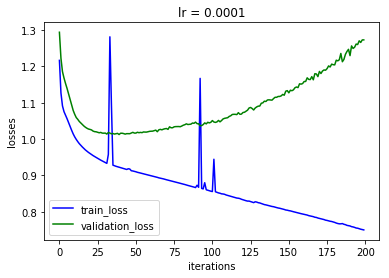

In [87]:
tf.reset_default_graph()
model = AttendanceTestModel(
                    cell_type = "lstm", activation_fn = "relu", num_epochs = 200,
                    pca_dim = 50, train_files_in_memory = True)
train(model)

### Test Output for Several Models
Scroll below for confusion matrices and T-SNE plots for several of my saved models.
You'll see the combined model has the best recall on the 1 dropout label, which is good because we want all dropouts to be predicted (ideally the goal should be to get 1 recall on dropout while later maximizing precision).

Based on the parameters of the model, it will be obvious what output you are seeing; the parameters are designed this way.

In [15]:
def test(model):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        model.predict(sess, saver)

Testing predictions on minibatches in following directory: ../data/clean/attendance/test/
***** LOADING WEIGHTS FROM EPOCH 50 *****
INFO:tensorflow:Restoring parameters from ../models/attendance_test_model/lstm_relu_memory_16_depth_1_window_6_weighted_pca_50/attendance_test_rnn-50
***** BEGIN TESTING - LOADING TEST FILES *****
Getting inputs and labels for filepath 0: ('../data/clean/attendance/test/attendance_minibatch_93.dill', '../data/clean/attendance/test/test_minibatch_93.dill')
Getting inputs and labels for filepath 1: ('../data/clean/attendance/test/attendance_minibatch_91.dill', '../data/clean/attendance/test/test_minibatch_91.dill')
Getting inputs and labels for filepath 2: ('../data/clean/attendance/test/attendance_minibatch_92.dill', '../data/clean/attendance/test/test_minibatch_92.dill')


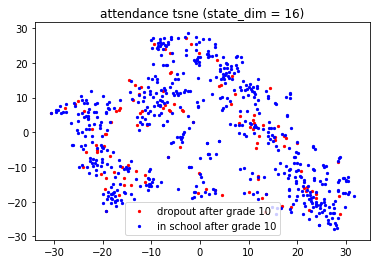

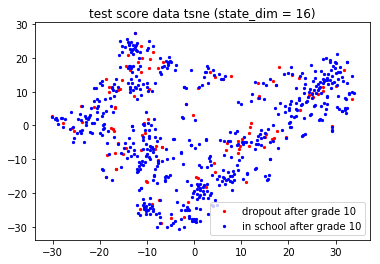

             precision    recall  f1-score   support

        0.0       0.90      0.71      0.79       563
        1.0       0.28      0.60      0.39       110

avg / total       0.80      0.69      0.72       673



In [90]:
tf.reset_default_graph()
model = AttendanceTestModel(
                    cell_type = "lstm", activation_fn = "relu", epoch_offset = 50, pca_dim = 50)
test(model)

Testing predictions on minibatches in following directory: ../data/clean/attendance/test/
***** LOADING WEIGHTS FROM EPOCH 200 *****
INFO:tensorflow:Restoring parameters from ../models/attendance_rnn/lstm_relu_memory_64_depth_1_window_6_weighted_pca_50/attendance_rnn-200
***** BEGIN TESTING - LOADING TEST FILES *****
Getting inputs and labels for filepath 0: ../data/clean/attendance/test/attendance_minibatch_91.dill
Getting inputs and labels for filepath 1: ../data/clean/attendance/test/attendance_minibatch_92.dill
Getting inputs and labels for filepath 2: ../data/clean/attendance/test/attendance_minibatch_93.dill


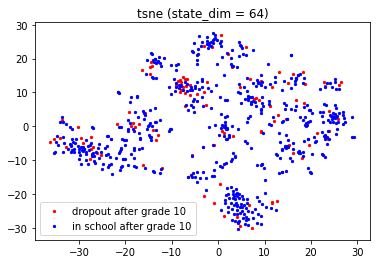

             precision    recall  f1-score   support

        0.0       0.87      0.70      0.78       563
        1.0       0.23      0.45      0.30       110

avg / total       0.76      0.66      0.70       673



In [20]:
tf.reset_default_graph()
model = AttendanceRNN(cell_type = "lstm", num_units = 64, activation_fn = "relu",
                      pca_dim = 50,
                      epoch_offset = 200)
test(model)

Testing predictions on minibatches in following directory: ../data/clean/attendance/test/
***** LOADING WEIGHTS FROM EPOCH 50 *****
INFO:tensorflow:Restoring parameters from ../models/attendance_rnn/lstm_relu_memory_16_depth_1_window_6_weighted/attendance_rnn-50
***** BEGIN TESTING - LOADING TEST FILES *****
Getting inputs and labels for filepath 0: ../data/clean/attendance/test/attendance_minibatch_92.dill
Getting inputs and labels for filepath 1: ../data/clean/attendance/test/attendance_minibatch_93.dill
Getting inputs and labels for filepath 2: ../data/clean/attendance/test/attendance_minibatch_91.dill


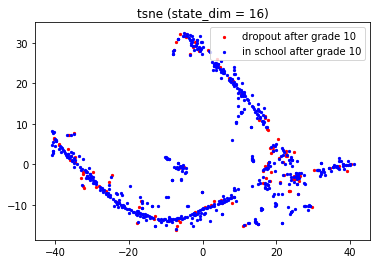

             precision    recall  f1-score   support

        0.0       0.88      0.69      0.77       563
        1.0       0.24      0.51      0.33       110

avg / total       0.77      0.66      0.70       673



In [21]:
tf.reset_default_graph()
model = AttendanceRNN(cell_type = "lstm", num_units = 16, activation_fn = "relu",
                      epoch_offset = 50)
test(model)

Testing predictions on minibatches in following directory: ../data/clean/attendance/test/
***** LOADING WEIGHTS FROM EPOCH 20 *****
INFO:tensorflow:Restoring parameters from ../models/attendance_rnn/rnn_tanh_memory_16_depth_1_window_6_weighted/attendance_rnn-20
***** BEGIN TESTING - LOADING TEST FILES *****
Getting inputs and labels for filepath 0: ../data/clean/attendance/test/attendance_minibatch_91.dill
Getting inputs and labels for filepath 1: ../data/clean/attendance/test/attendance_minibatch_92.dill
Getting inputs and labels for filepath 2: ../data/clean/attendance/test/attendance_minibatch_93.dill


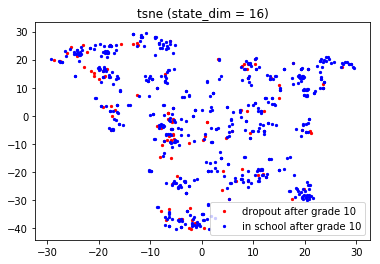

             precision    recall  f1-score   support

        0.0       0.87      0.69      0.77       563
        1.0       0.23      0.47      0.31       110

avg / total       0.76      0.65      0.69       673



In [23]:
tf.reset_default_graph()
model = AttendanceRNN(cell_type = "rnn", num_units = 16, activation_fn = "tanh",
                      epoch_offset = 20)
test(model)

Testing predictions on minibatches in following directory: ../data/clean/attendance/test/
***** LOADING WEIGHTS FROM EPOCH 20 *****
INFO:tensorflow:Restoring parameters from ../models/attendance_rnn/lstm_tanh_memory_16_depth_1_window_6_weighted/attendance_rnn-20
***** BEGIN TESTING - LOADING TEST FILES *****
Getting inputs and labels for filepath 0: ../data/clean/attendance/test/attendance_minibatch_93.dill
Getting inputs and labels for filepath 1: ../data/clean/attendance/test/attendance_minibatch_92.dill
Getting inputs and labels for filepath 2: ../data/clean/attendance/test/attendance_minibatch_91.dill


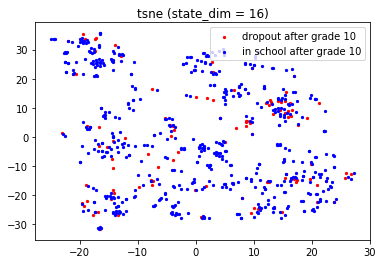

             precision    recall  f1-score   support

        0.0       0.88      0.68      0.77       563
        1.0       0.24      0.51      0.32       110

avg / total       0.77      0.65      0.69       673



In [24]:
tf.reset_default_graph()
model = AttendanceRNN(cell_type = "lstm", num_units = 16, activation_fn = "tanh",
                      epoch_offset = 20)
test(model)

Thank you for a great quarter! I feel like I can belong in the deep learning world now, thanks to you guys.

We didn't look at papers in industry to inform our decisions, and we should have, but we just ran out of time. I'm going to look into economic time series models as I continue the project, but for now there's nothing to cite.